In [34]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF

import time

from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

import wandb

---

# Schritt 3: Basismodell aufbauen, W&B-Integration & Evaluation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [29]:
# Hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "baseline_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "BaselineCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▃▄▅▆▆▆▇▇▇▇████
train_loss,██▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇█▇███
val_loss,█▆▅▄▃▃▃▂▂▂▁▂▁▁▁
cv_mean_accuracy,65.32
cv_std_accuracy,0.24331


## Dataset laden und splitten

In [3]:
# (a) Define transforms (you can add augmentations here if you like)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # optional: random crop + padding
    transforms.RandomHorizontalFlip(),          # optional: random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [4]:
cifar10_train_full = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

In [5]:
train_len = int(0.85 * len(cifar10_train_full))
val_len   = len(cifar10_train_full) - train_len

train_ds, val_ds = random_split(
    cifar10_train_full,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

print("Train dataset length:", len(train_ds))
print("Validation dataset length:", len(val_ds))

Train dataset length: 42500
Validation dataset length: 7500


In [7]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(cifar10_test)}")
print("Classes:", cifar10_train_full.classes)

Train/Val/Test sizes: 42500/7500/10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
cifar10_train_for_cv = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=False,
    transform=transform_test  # only normalization for consistent CV evaluation
)

## Modell-Definition: BaselineCNN

In [9]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
num_classes = len(cifar10_train_full.classes)  # should be 10
model = BaselineCNN(num_classes).to(device)
wandb.watch(model, log="all", log_freq=10)
print(model)

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Train-/Eval-Funktionen definieren

In [12]:
def train_one_epoch(model, loader, criterion, optimizer, epoch=None, log_to_wandb=True):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds    = outputs.max(1)
        correct    += (preds == labels).sum().item()
        total      += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, epoch=None, log_to_wandb=True, split_name="val"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds     = outputs.max(1)
            correct      += (preds == labels).sum().item()
            total        += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and epoch is not None:
        wandb.log({
            f"{split_name}_loss": epoch_loss,
            f"{split_name}_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc


def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs,   label="Val Acc")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Overfitting-Test auf einem Einzel‐Sample

In [38]:
ov_model = BaselineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ov_model.parameters(), lr=0.01, momentum=0.9)

# Take the first sample from train_ds (after our split)
sample_img, sample_lbl = train_ds[0]
sample_img = sample_img.unsqueeze(0).to(device)
sample_lbl = torch.tensor([sample_lbl], dtype=torch.long).to(device)

print(">>> Single-Sample Overfitting Test:")
for epoch in range(1, 21):
    ov_model.train()
    optimizer.zero_grad()
    out   = ov_model(sample_img)
    loss  = criterion(out, sample_lbl)
    loss.backward()
    optimizer.step()
    _, pred = out.max(1)
    acc     = 100 * (pred == sample_lbl).float().item()
    print(f"Epoch {epoch:02d}: Loss={loss.item():.4f}, Acc={acc:.1f}%")

>>> Single-Sample Overfitting Test:
Epoch 01: Loss=2.1559, Acc=100.0%
Epoch 02: Loss=1.9752, Acc=100.0%
Epoch 03: Loss=1.6713, Acc=100.0%
Epoch 04: Loss=1.1585, Acc=100.0%
Epoch 05: Loss=0.4291, Acc=100.0%
Epoch 06: Loss=0.0364, Acc=100.0%
Epoch 07: Loss=0.0008, Acc=100.0%
Epoch 08: Loss=0.0000, Acc=100.0%
Epoch 09: Loss=0.0000, Acc=100.0%
Epoch 10: Loss=0.0000, Acc=100.0%
Epoch 11: Loss=0.0000, Acc=100.0%
Epoch 12: Loss=0.0000, Acc=100.0%
Epoch 13: Loss=0.0000, Acc=100.0%
Epoch 14: Loss=0.0000, Acc=100.0%
Epoch 15: Loss=0.0000, Acc=100.0%
Epoch 16: Loss=0.0000, Acc=100.0%
Epoch 17: Loss=0.0000, Acc=100.0%
Epoch 18: Loss=0.0000, Acc=100.0%
Epoch 19: Loss=0.0000, Acc=100.0%
Epoch 20: Loss=0.0000, Acc=100.0%


## Training auf dem gesamten Trainingsset

>>> Training on CIFAR-10 train/val starts ...
Epoche 01: Train L=1.6157, A=40.6%;  Val L=1.3372, A=51.2%
Epoche 02: Train L=1.2764, A=54.4%;  Val L=1.2067, A=57.4%
Epoche 03: Train L=1.1387, A=60.0%;  Val L=1.1112, A=61.4%
Epoche 04: Train L=1.0673, A=62.7%;  Val L=1.0175, A=63.7%
Epoche 05: Train L=1.0181, A=64.7%;  Val L=1.0006, A=65.1%
Epoche 06: Train L=0.9821, A=65.9%;  Val L=0.9713, A=66.2%
Epoche 07: Train L=0.9473, A=67.1%;  Val L=0.9913, A=66.6%
Epoche 08: Train L=0.9281, A=68.0%;  Val L=1.0082, A=64.8%
Epoche 09: Train L=0.9068, A=68.9%;  Val L=0.9812, A=65.9%
Epoche 10: Train L=0.8941, A=69.2%;  Val L=1.0326, A=65.6%
Epoche 11: Train L=0.8803, A=69.9%;  Val L=0.9368, A=68.8%
Epoche 12: Train L=0.8665, A=70.2%;  Val L=0.9305, A=69.1%
Epoche 13: Train L=0.8522, A=71.0%;  Val L=0.9430, A=68.2%
Epoche 14: Train L=0.8438, A=71.2%;  Val L=0.9122, A=69.3%
Epoche 15: Train L=0.8422, A=71.3%;  Val L=0.9344, A=69.1%


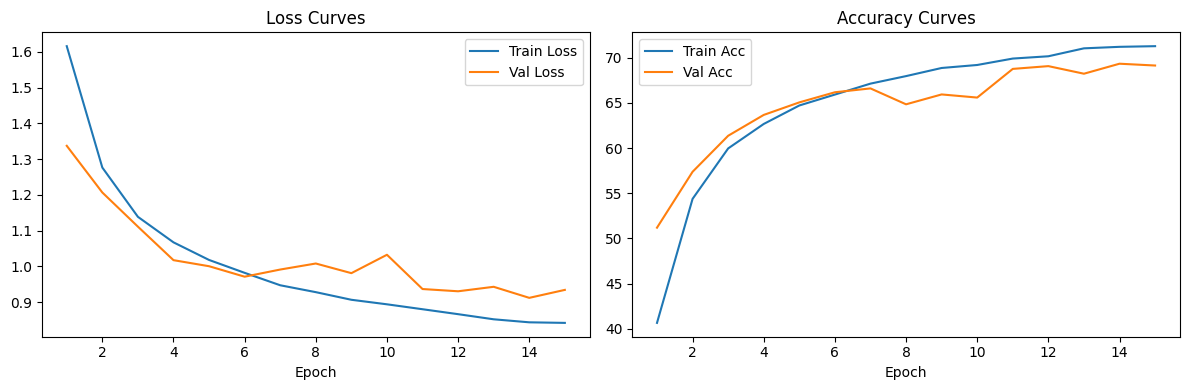

In [39]:
model      = BaselineCNN(num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

print(">>> Training on CIFAR-10 train/val starts ...")
for ep in range(1, epochs + 1):
    # training
    tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, ep)

    # validation
    vl, va = eval_one_epoch(
        model,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses.append(tl)
    train_accs.append(ta)
    val_losses.append(vl)
    val_accs.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

## Berechnung weiterer Metriken auf Test‐Set

In [13]:
def compute_metrics(model, loader):
    all_lbls, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            _, preds = outs.max(1)
            all_lbls.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())
    p = precision_score(all_lbls, all_preds, average="macro")
    r = recall_score(all_lbls, all_preds, average="macro")
    f = f1_score(all_lbls, all_preds, average="macro")
    return p, r, f

In [ ]:
precision, recall, f1 = compute_metrics(model, test_loader)
_, test_acc = eval_one_epoch(model, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc:.1f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

wandb.log({
    "test_accuracy": test_acc,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1
})

Test Accuracy: 72.3%
Precision: 0.728, Recall: 0.723, F1: 0.721


## 5-Fold Cross-Validation

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accs = []

print(">>> 5-Fold CV on entire CIFAR-10 train set starts ...")
for fold, (tr_idx, va_idx) in enumerate(kf.split(cifar10_train_for_cv), start=1):
    tr_ds = Subset(cifar10_train_for_cv, tr_idx)
    va_ds = Subset(cifar10_train_for_cv, va_idx)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    m_cv = BaselineCNN(num_classes).to(device)
    opt = optim.SGD(m_cv.parameters(), lr=learning_rate, momentum=0.9)
    crit = nn.CrossEntropyLoss()

    # Only 5 epochs per fold (as an example)
    for _ in range(5):
        _, _ = train_one_epoch(m_cv, tr_ld, crit, opt, epoch=None, log_to_wandb=False)
    _, acc = eval_one_epoch(m_cv, va_ld, crit, epoch=None, log_to_wandb=False, split_name="cv")
    fold_accs.append(acc)
    print(f"Fold {fold}: Val Acc = {acc:.2f}%")

mean_acc = np.mean(fold_accs)
std_acc  = np.std(fold_accs)
print(f"\nCV Results: Mean = {mean_acc:.2f}%, Std = {std_acc:.2f}%")

wandb.summary['cv_mean_accuracy'] = mean_acc
wandb.summary['cv_std_accuracy']  = std_acc

>>> 5-Fold CV on entire CIFAR-10 train set starts ...
Fold 1: Val Acc = 67.88%
Fold 2: Val Acc = 68.42%
Fold 3: Val Acc = 67.12%
Fold 4: Val Acc = 67.72%
Fold 5: Val Acc = 66.21%

CV Results: Mean = 67.47%, Std = 0.75%


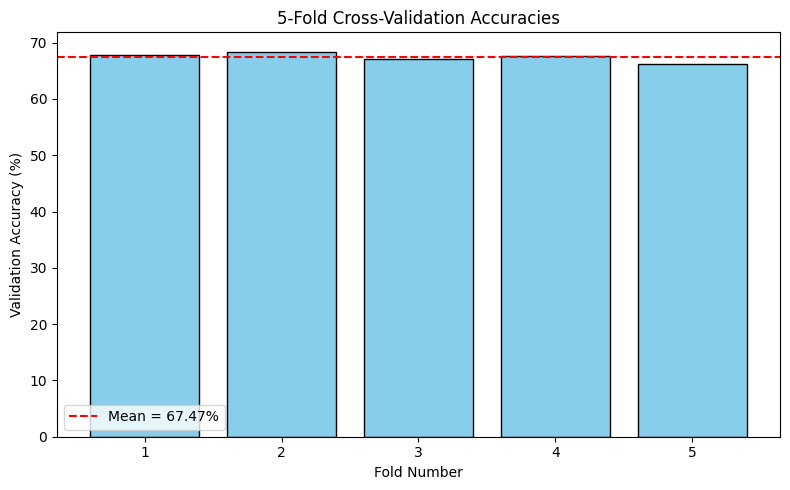

In [42]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(fold_accs) + 1),
        fold_accs,
        color='skyblue',
        edgecolor='black')

# Mittelwert berechnen und als gestrichelte Linie einzeichnen
mean_val = sum(fold_accs) / len(fold_accs)
plt.axhline(y=mean_val,
            linestyle='--',
            color='red',
            label=f'Mean = {mean_val:.2f}%')

plt.title('5-Fold Cross-Validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy (%)')
plt.xticks(range(1, len(fold_accs) + 1))
plt.legend()
plt.tight_layout()
plt.show()

---

## Hypothese 1: Kleinere Lernrate

Wenn wir die Lernrate von 0.01 (Baseline) auf 0.001 reduzieren, wird
 - der Trainings­verlust langsamer sinken,
 - die Validierungs­Accuracy ggf. gleichbleiben oder leicht steigen (weil kleinere Schritte stabiler sind),
 - und das Risiko eines plötzlich ansteigenden Loss-Abweichers (Loss-Explosion) geringer.

Begründung/Theorie:
Kleine Lernraten führen zu kleineren Gewichtsanpassungen je Schritt. Dadurch wandert das Modell langsamer, aber präziser durch den Parameterraum. In manchen Fällen verhindert das Überschreiten von Minima.

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▆▇▇█████
val_loss,█▆▄▃▂▂▂▃▂▃▁▁▂▁▁
cv_mean_accuracy,67.47
cv_std_accuracy,0.75408


>>> Training on CIFAR-10 train/val starts ...
Epoche 01: Train L=1.8981, A=30.7%;  Val L=1.6155, A=41.3%
Epoche 02: Train L=1.5248, A=44.2%;  Val L=1.4539, A=46.7%
Epoche 03: Train L=1.3932, A=49.8%;  Val L=1.3230, A=52.2%
Epoche 04: Train L=1.2853, A=53.8%;  Val L=1.2427, A=55.5%
Epoche 05: Train L=1.1952, A=57.2%;  Val L=1.1513, A=58.7%
Epoche 06: Train L=1.1237, A=60.2%;  Val L=1.1210, A=59.5%
Epoche 07: Train L=1.0652, A=62.2%;  Val L=1.0735, A=62.2%
Epoche 08: Train L=1.0161, A=64.2%;  Val L=1.0331, A=63.0%
Epoche 09: Train L=0.9799, A=65.3%;  Val L=0.9739, A=66.0%
Epoche 10: Train L=0.9421, A=66.5%;  Val L=0.9404, A=67.1%
Epoche 11: Train L=0.9099, A=67.9%;  Val L=0.9545, A=66.0%
Epoche 12: Train L=0.8833, A=68.8%;  Val L=0.9564, A=66.2%
Epoche 13: Train L=0.8610, A=69.7%;  Val L=0.8938, A=68.3%
Epoche 14: Train L=0.8364, A=70.2%;  Val L=0.8739, A=69.3%
Epoche 15: Train L=0.8112, A=71.6%;  Val L=0.8766, A=69.2%


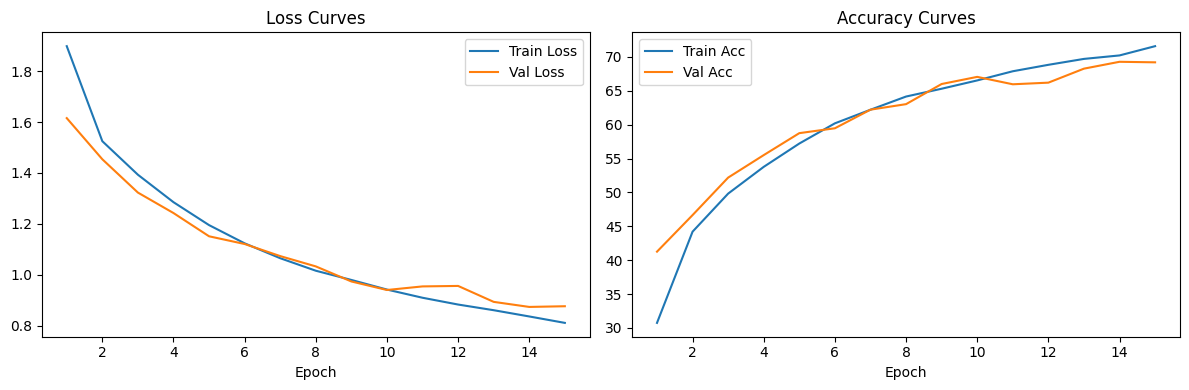

In [ ]:
# Hyperparameter
epochs = 15
batch_size = 16
learning_rate_1 = 0.001
project_name = "image-classification"
run_name = "lower_lr_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "LowerLRCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model      = BaselineCNN(num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.9)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

print(">>> Training on CIFAR-10 train/val starts ...")
for ep in range(1, epochs + 1):
    # training
    tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, ep)

    # validation
    vl, va = eval_one_epoch(
        model,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses.append(tl)
    train_accs.append(ta)
    val_losses.append(vl)
    val_accs.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.1f}%;  Val L={vl:.4f}, A={va:.1f}%")

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [44]:
precision, recall, f1 = compute_metrics(model, test_loader)
_, test_acc = eval_one_epoch(model, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc:.1f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

wandb.log({
    "test_accuracy": test_acc,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1_score": f1
})

Test Accuracy: 72.5%
Precision: 0.731, Recall: 0.725, F1: 0.725


---

## Hypothese 2: Grössere Batchsize

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
train_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇███
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
epoch,15
test_accuracy,72.46


>>> Training on CIFAR-10 train/val with larger batch size starts ...
Epoche 01: Train L=1.7480, A=35.8%;  Val L=1.5431, A=43.0%
Epoche 02: Train L=1.3958, A=49.2%;  Val L=1.2925, A=52.8%
Epoche 03: Train L=1.2166, A=56.2%;  Val L=1.1874, A=57.4%
Epoche 04: Train L=1.0950, A=60.8%;  Val L=1.0630, A=62.7%
Epoche 05: Train L=1.0136, A=63.8%;  Val L=1.0203, A=64.0%
Epoche 06: Train L=0.9543, A=66.2%;  Val L=0.9688, A=66.1%
Epoche 07: Train L=0.9063, A=68.1%;  Val L=0.9356, A=66.7%
Epoche 08: Train L=0.8706, A=69.5%;  Val L=0.8697, A=69.3%
Epoche 09: Train L=0.8366, A=70.6%;  Val L=0.8714, A=69.1%
Epoche 10: Train L=0.8088, A=71.6%;  Val L=0.8877, A=69.4%
Epoche 11: Train L=0.7784, A=72.7%;  Val L=0.8261, A=71.1%
Epoche 12: Train L=0.7573, A=73.4%;  Val L=0.8048, A=71.7%
Epoche 13: Train L=0.7333, A=74.5%;  Val L=0.8040, A=72.1%
Epoche 14: Train L=0.7242, A=74.7%;  Val L=0.7785, A=73.1%
Epoche 15: Train L=0.7083, A=75.4%;  Val L=0.7506, A=73.9%


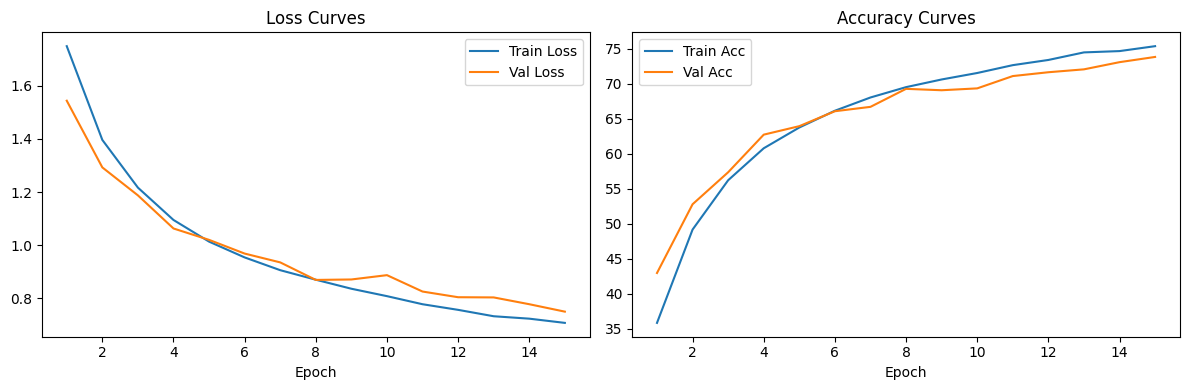

In [45]:
# Hyperparameter
epochs = 15
batch_size_2 = 64
learning_rate = 0.01
project_name = "image-classification"
run_name = "larger_batch_size_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "LargerBatchSizeCNN",
        "epochs": epochs,
        "batch_size": batch_size_2,
        "learning_rate": learning_rate
    }
)

train_loader_2 = DataLoader(train_ds, batch_size=batch_size_2, shuffle=True, num_workers=2, pin_memory=True)
val_loader_2   = DataLoader(val_ds,   batch_size=batch_size_2, shuffle=False, num_workers=2, pin_memory=True)
model_2 = BaselineCNN(num_classes).to(device)
opt_2   = optim.SGD(model_2.parameters(), lr=learning_rate, momentum=0.9)

train_losses_2, val_losses_2 = [], []
train_accs_2, val_accs_2 = [], []

print(">>> Training on CIFAR-10 train/val with larger batch size starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_2, ta_2 = train_one_epoch(model_2, train_loader_2, criterion, opt_2, ep)

    # validation
    vl_2, va_2 = eval_one_epoch(
        model_2,
        val_loader_2,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_2.append(tl_2)
    train_accs_2.append(ta_2)
    val_losses_2.append(vl_2)
    val_accs_2.append(va_2)
    print(f"Epoche {ep:02d}: Train L={tl_2:.4f}, A={ta_2:.1f}%;  Val L={vl_2:.4f}, A={va_2:.1f}%")

plot_learning_curves(train_losses_2, val_losses_2, train_accs_2, val_accs_2)

In [46]:
precision_2, recall_2, f1_2 = compute_metrics(model_2, test_loader)
_, test_acc_2 = eval_one_epoch(model_2, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_2:.1f}%")
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1: {f1_2:.3f}")

wandb.log({
    "test_accuracy": test_acc_2,
    "test_precision": precision_2,
    "test_recall": recall_2,
    "test_f1_score": f1_2
})

Test Accuracy: 76.1%
Precision: 0.762, Recall: 0.761, F1: 0.760


---

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▇▇▇▇█████
train_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
test_accuracy,76.14


>>> Training on CIFAR-10 train/val with Xavier initialization starts ...
Epoche 01: Train L=1.6028, A=41.4%;  Val L=1.4318, A=47.2%
Epoche 02: Train L=1.2778, A=54.1%;  Val L=1.1780, A=58.3%
Epoche 03: Train L=1.1640, A=59.0%;  Val L=1.1553, A=59.8%
Epoche 04: Train L=1.0888, A=61.8%;  Val L=1.1171, A=60.8%
Epoche 05: Train L=1.0409, A=63.8%;  Val L=1.0982, A=62.2%
Epoche 06: Train L=1.0036, A=65.1%;  Val L=0.9856, A=65.9%
Epoche 07: Train L=0.9798, A=66.0%;  Val L=1.0050, A=64.9%
Epoche 08: Train L=0.9530, A=67.0%;  Val L=0.9924, A=66.5%
Epoche 09: Train L=0.9311, A=67.9%;  Val L=1.0278, A=66.3%
Epoche 10: Train L=0.9136, A=68.6%;  Val L=0.9976, A=66.3%
Epoche 11: Train L=0.9044, A=68.6%;  Val L=1.0547, A=65.4%
Epoche 12: Train L=0.8890, A=69.3%;  Val L=0.9327, A=67.9%
Epoche 13: Train L=0.8774, A=70.0%;  Val L=0.9503, A=68.4%
Epoche 14: Train L=0.8755, A=70.1%;  Val L=0.9416, A=68.4%
Epoche 15: Train L=0.8665, A=70.6%;  Val L=0.9105, A=69.0%


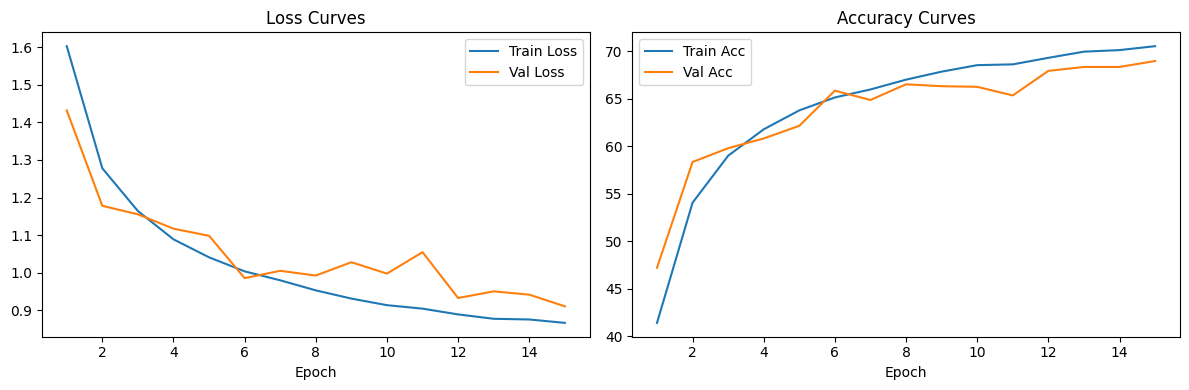

In [47]:
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "xavier_init_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "XavierInitCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_xavier = BaselineCNN(num_classes).to(device)
model_xavier.apply(init_weights_xavier)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_xavier.parameters(), lr=learning_rate, momentum=0.9)

train_losses_xavier, val_losses_xavier = [], []
train_accs_xavier, val_accs_xavier = [], []

print(">>> Training on CIFAR-10 train/val with Xavier initialization starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_xavier, ta_xavier = train_one_epoch(model_xavier, train_loader, criterion, optimizer, ep)

    # validation
    vl_xavier, va_xavier = eval_one_epoch(
        model_xavier,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_xavier.append(tl_xavier)
    train_accs_xavier.append(ta_xavier)
    val_losses_xavier.append(vl_xavier)
    val_accs_xavier.append(va_xavier)
    print(f"Epoche {ep:02d}: Train L={tl_xavier:.4f}, A={ta_xavier:.1f}%;  Val L={vl_xavier:.4f}, A={va_xavier:.1f}%")

plot_learning_curves(train_losses_xavier, val_losses_xavier, train_accs_xavier, val_accs_xavier)

In [48]:
precision_xavier, recall_xavier, f1_xavier = compute_metrics(model_xavier, test_loader)
_, test_acc_xavier = eval_one_epoch(model_xavier, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_xavier:.1f}%")
print(f"Precision: {precision_xavier:.3f}, Recall: {recall_xavier:.3f}, F1: {f1_xavier:.3f}")

wandb.log({
    "test_accuracy": test_acc_xavier,
    "test_precision": precision_xavier,
    "test_recall": recall_xavier,
    "test_f1_score": f1_xavier
})

Test Accuracy: 70.9%
Precision: 0.716, Recall: 0.709, F1: 0.708


---

In [49]:
class ExtendedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # neues Layer
        self.fc1   = nn.Linear(128 * 4 * 4, 256)  # Achtung: räumliche Dimension halbiert sich dreimal
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(torch.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(x.size(0), -1)                  # [B, 128*4*4]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)        

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Params BaselineCNN:", count_parameters(BaselineCNN(num_classes)))
print("Params ExtendedCNN:", count_parameters(ExtendedCNN(num_classes)))

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▅▅▆▇▇▇▇▇▇████
val_loss,█▅▄▄▄▂▂▂▃▂▃▁▂▁▁
epoch,15
test_accuracy,70.88


>>> Training on CIFAR-10 train/val with ExtendedCNN starts ...
Epoche 01: Train L=1.6464, A=39.2%;  Val L=1.4062, A=49.3%
Epoche 02: Train L=1.2295, A=56.0%;  Val L=1.0775, A=61.8%
Epoche 03: Train L=1.0619, A=62.6%;  Val L=1.0388, A=63.3%
Epoche 04: Train L=0.9706, A=66.1%;  Val L=0.9361, A=66.9%
Epoche 05: Train L=0.9230, A=68.0%;  Val L=0.9569, A=67.2%
Epoche 06: Train L=0.8836, A=69.6%;  Val L=0.8852, A=69.0%
Epoche 07: Train L=0.8579, A=70.4%;  Val L=0.8871, A=70.0%
Epoche 08: Train L=0.8463, A=71.2%;  Val L=0.8882, A=69.8%
Epoche 09: Train L=0.8300, A=71.6%;  Val L=0.9247, A=69.1%
Epoche 10: Train L=0.8302, A=71.8%;  Val L=0.8919, A=69.9%
Epoche 11: Train L=0.8139, A=72.5%;  Val L=0.9261, A=69.4%
Epoche 12: Train L=0.8122, A=72.5%;  Val L=0.8888, A=70.0%
Epoche 13: Train L=0.8066, A=72.8%;  Val L=0.8416, A=71.8%
Epoche 14: Train L=0.8001, A=73.3%;  Val L=0.9427, A=69.5%
Epoche 15: Train L=0.7984, A=73.2%;  Val L=0.9532, A=69.1%


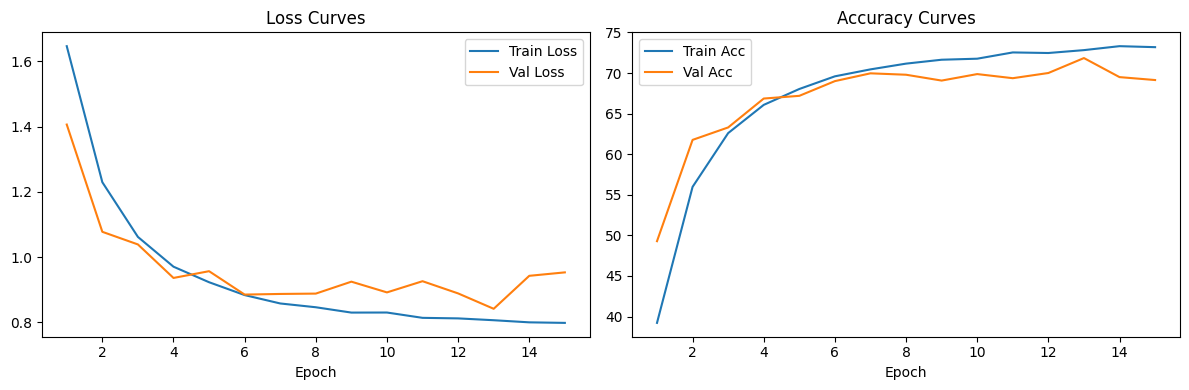

In [52]:
# Hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "extended_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "ExtendedCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_extended = ExtendedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_extended.parameters(), lr=learning_rate, momentum=0.9)

train_losses_extended, val_losses_extended = [], []
train_accs_extended, val_accs_extended = [], []

print(">>> Training on CIFAR-10 train/val with ExtendedCNN starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_extended, ta_extended = train_one_epoch(model_extended, train_loader, criterion, optimizer, ep)

    # validation
    vl_extended, va_extended = eval_one_epoch(
        model_extended,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_extended.append(tl_extended)
    train_accs_extended.append(ta_extended)
    val_losses_extended.append(vl_extended)
    val_accs_extended.append(va_extended)
    print(f"Epoche {ep:02d}: Train L={tl_extended:.4f}, A={ta_extended:.1f}%;  Val L={vl_extended:.4f}, A={va_extended:.1f}%")
    
plot_learning_curves(train_losses_extended, val_losses_extended, train_accs_extended, val_accs_extended)

In [53]:
precision_extended, recall_extended, f1_extended = compute_metrics(model_extended, test_loader)
_, test_acc_extended = eval_one_epoch(model_extended, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_extended:.1f}%")
print(f"Precision: {precision_extended:.3f}, Recall: {recall_extended:.3f}, F1: {f1_extended:.3f}")

wandb.log({
    "test_accuracy": test_acc_extended,
    "test_precision": precision_extended,
    "test_recall": recall_extended,
    "test_f1_score": f1_extended
})

Test Accuracy: 71.1%
Precision: 0.725, Recall: 0.711, F1: 0.709


---

In [54]:
class FilteredCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # statt 32 nun 64 Filter
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # statt 64 nun 128 Filter
        self.fc1   = nn.Linear(128 * 8 * 8, 256)  # mehr Feature-Maps, also Größe anpassen
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 64, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 128, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 128*8*8]
        x = torch.relu(self.fc1(x))                # [B, 256]
        return self.fc2(x)

In [55]:
print("Params FilteredCNN:", count_parameters(FilteredCNN(num_classes)))

Params FilteredCNN: 2175626


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆▇▇▇▇████████
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇▇▇▇▇▇█▇▇
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▁▂▂
epoch,15
test_accuracy,71.07


>>> Training on CIFAR-10 train/val with FilteredCNN starts ...
Epoche 01: Train L=1.5659, A=42.4%;  Val L=1.2701, A=53.8%
Epoche 02: Train L=1.2007, A=57.2%;  Val L=1.1434, A=60.3%
Epoche 03: Train L=1.0616, A=62.6%;  Val L=1.0081, A=65.5%
Epoche 04: Train L=0.9724, A=66.0%;  Val L=0.9830, A=65.8%
Epoche 05: Train L=0.9165, A=68.2%;  Val L=0.9734, A=67.1%
Epoche 06: Train L=0.8741, A=69.6%;  Val L=0.8853, A=69.1%
Epoche 07: Train L=0.8419, A=70.9%;  Val L=0.8832, A=69.9%
Epoche 08: Train L=0.8056, A=72.0%;  Val L=0.8491, A=71.0%
Epoche 09: Train L=0.7835, A=72.9%;  Val L=0.8234, A=71.7%
Epoche 10: Train L=0.7639, A=73.7%;  Val L=0.8492, A=71.0%
Epoche 11: Train L=0.7513, A=74.4%;  Val L=0.8902, A=69.5%
Epoche 12: Train L=0.7317, A=75.0%;  Val L=0.8656, A=71.8%
Epoche 13: Train L=0.7203, A=75.3%;  Val L=0.8762, A=71.3%
Epoche 14: Train L=0.7032, A=76.2%;  Val L=0.8710, A=71.5%
Epoche 15: Train L=0.6897, A=76.5%;  Val L=0.8236, A=73.3%


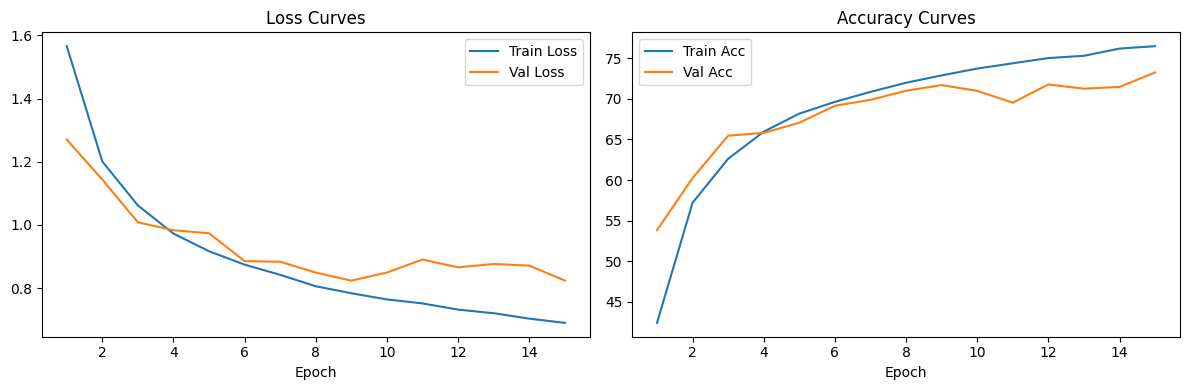

In [56]:
#hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "filtered_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "FilteredCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_filtered = FilteredCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_filtered.parameters(), lr=learning_rate, momentum=0.9)

train_losses_filtered, val_losses_filtered = [], []
train_accs_filtered, val_accs_filtered = [], []

print(">>> Training on CIFAR-10 train/val with FilteredCNN starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_filtered, ta_filtered = train_one_epoch(model_filtered, train_loader, criterion, optimizer, ep)

    # validation
    vl_filtered, va_filtered = eval_one_epoch(
        model_filtered,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_filtered.append(tl_filtered)
    train_accs_filtered.append(ta_filtered)
    val_losses_filtered.append(vl_filtered)
    val_accs_filtered.append(va_filtered)
    
    print(f"Epoche {ep:02d}: Train L={tl_filtered:.4f}, A={ta_filtered:.1f}%;  Val L={vl_filtered:.4f}, A={va_filtered:.1f}%")
    
plot_learning_curves(train_losses_filtered, val_losses_filtered, train_accs_filtered, val_accs_filtered)

In [57]:
precision_filtered, recall_filtered, f1_filtered = compute_metrics(model_filtered, test_loader)
_, test_acc_filtered = eval_one_epoch(model_filtered, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_filtered:.1f}%")
print(f"Precision: {precision_filtered:.3f}, Recall: {recall_filtered:.3f}, F1: {f1_filtered:.3f}")

wandb.log({
    "test_accuracy": test_acc_filtered,
    "test_precision": precision_filtered,
    "test_recall": recall_filtered,
    "test_f1_score": f1_filtered
})

Test Accuracy: 75.1%
Precision: 0.761, Recall: 0.751, F1: 0.751


---

In [14]:
class kernel_size_5_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Padding=2, damit Ausgangsdimension gleich bleibt
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x)

In [17]:
print("Params kernel_size_5_CNN:", count_parameters(kernel_size_5_CNN(num_classes)))

Params kernel_size_5_CNN: 579402


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oliver-pejic (oliver-pejic-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


>>> Training on CIFAR-10 train/val with kernel_size_5_CNN starts ...
Epoche 01: Train L=1.6570, A=39.1%;  Val L=1.4640, A=45.3%
Epoche 02: Train L=1.3385, A=52.2%;  Val L=1.2355, A=56.4%
Epoche 03: Train L=1.2020, A=57.9%;  Val L=1.2877, A=55.1%
Epoche 04: Train L=1.1337, A=60.7%;  Val L=1.1053, A=61.2%
Epoche 05: Train L=1.0963, A=61.9%;  Val L=1.1714, A=59.5%
Epoche 06: Train L=1.0578, A=63.9%;  Val L=1.1540, A=61.1%
Epoche 07: Train L=1.0302, A=64.8%;  Val L=1.0402, A=64.7%
Epoche 08: Train L=1.0170, A=65.3%;  Val L=1.0901, A=62.1%
Epoche 09: Train L=1.0058, A=65.9%;  Val L=1.0266, A=65.1%
Epoche 10: Train L=0.9882, A=66.3%;  Val L=1.0510, A=65.2%
Epoche 11: Train L=0.9838, A=66.8%;  Val L=1.0853, A=64.5%
Epoche 12: Train L=0.9771, A=67.2%;  Val L=1.1380, A=63.7%
Epoche 13: Train L=0.9618, A=67.7%;  Val L=1.0769, A=65.4%
Epoche 14: Train L=0.9538, A=68.0%;  Val L=1.0083, A=66.9%
Epoche 15: Train L=0.9502, A=68.1%;  Val L=1.0559, A=65.6%


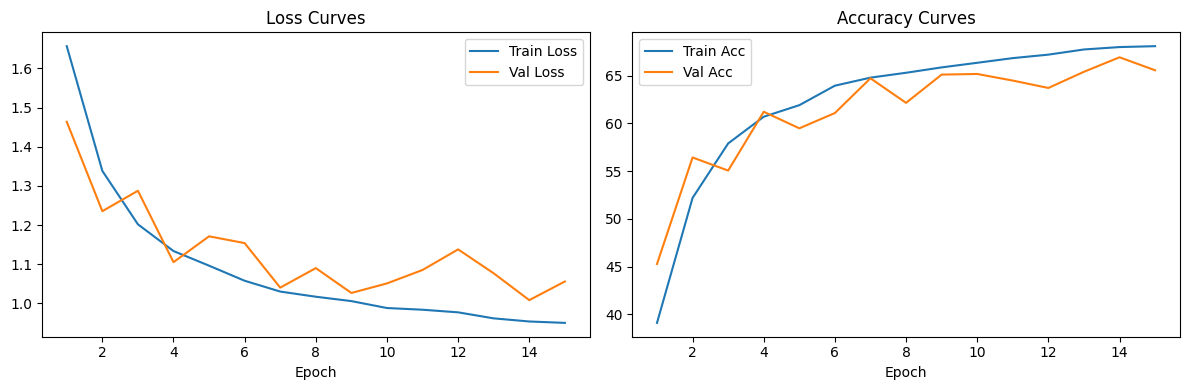

In [18]:
#hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "kernel_size_5_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "kernel_size_5_CNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_5 = kernel_size_5_CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_5.parameters(), lr=learning_rate, momentum=0.9)

train_losses_5, val_losses_5 = [], []
train_accs_5, val_accs_5 = [], []

print(">>> Training on CIFAR-10 train/val with kernel_size_5_CNN starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_5, ta_5 = train_one_epoch(model_5, train_loader, criterion, optimizer, ep)

    # validation
    vl_5, va_5 = eval_one_epoch(
        model_5,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_5.append(tl_5)
    train_accs_5.append(ta_5)
    val_losses_5.append(vl_5)
    val_accs_5.append(va_5)
    
    print(f"Epoche {ep:02d}: Train L={tl_5:.4f}, A={ta_5:.1f}%;  Val L={vl_5:.4f}, A={va_5:.1f}%")
    
plot_learning_curves(train_losses_5, val_losses_5, train_accs_5, val_accs_5)

In [19]:
precision_5, recall_5, f1_5 = compute_metrics(model_5, test_loader)
_, test_acc_5 = eval_one_epoch(model_5, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_5:.1f}%")
print(f"Precision: {precision_5:.3f}, Recall: {recall_5:.3f}, F1: {f1_5:.3f}")
wandb.log({
    "test_accuracy": test_acc_5,
    "test_precision": precision_5,
    "test_recall": recall_5,
    "test_f1_score": f1_5
})

Test Accuracy: 68.2%
Precision: 0.693, Recall: 0.682, F1: 0.684


---

In [20]:
class NoPoolingCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # kein Pooling nach conv2
        self.fc1   = nn.Linear(64 * 16 * 16, 128)  # räumliche Dimension bleibt 16×16
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = torch.relu(self.conv2(x))              # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)                  # [B, 64*16*16]
        x = torch.relu(self.fc1(x))                # [B, 128]
        return self.fc2(x)

In [21]:
print("Params NoPoolingCNN:", count_parameters(NoPoolingCNN(num_classes)))

Params NoPoolingCNN: 2117962


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▆▆▇▇▇▇▇██████
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▄▆▆▆▇▆▇▇▇▇███
val_loss,█▄▅▂▄▃▁▂▁▂▂▃▂▁▂
epoch,15
test_accuracy,68.22


>>> Training on CIFAR-10 train/val with NoPoolingCNN starts ...
Epoche 01: Train L=1.6577, A=39.1%;  Val L=1.3896, A=48.9%
Epoche 02: Train L=1.3458, A=51.5%;  Val L=1.2935, A=53.9%
Epoche 03: Train L=1.2215, A=57.3%;  Val L=1.1598, A=59.1%
Epoche 04: Train L=1.1317, A=60.2%;  Val L=1.1181, A=60.5%
Epoche 05: Train L=1.0803, A=62.5%;  Val L=1.0627, A=62.9%
Epoche 06: Train L=1.0447, A=63.5%;  Val L=1.0970, A=63.1%
Epoche 07: Train L=1.0143, A=65.1%;  Val L=0.9933, A=65.4%
Epoche 08: Train L=0.9808, A=66.0%;  Val L=1.0178, A=64.9%
Epoche 09: Train L=0.9688, A=66.3%;  Val L=1.0032, A=65.8%
Epoche 10: Train L=0.9466, A=67.6%;  Val L=1.0050, A=65.9%
Epoche 11: Train L=0.9255, A=68.3%;  Val L=0.9918, A=66.5%
Epoche 12: Train L=0.9120, A=68.5%;  Val L=0.9495, A=67.3%
Epoche 13: Train L=0.9002, A=69.2%;  Val L=0.9656, A=66.8%
Epoche 14: Train L=0.8838, A=69.5%;  Val L=0.9700, A=66.7%
Epoche 15: Train L=0.8807, A=70.0%;  Val L=0.9345, A=67.3%


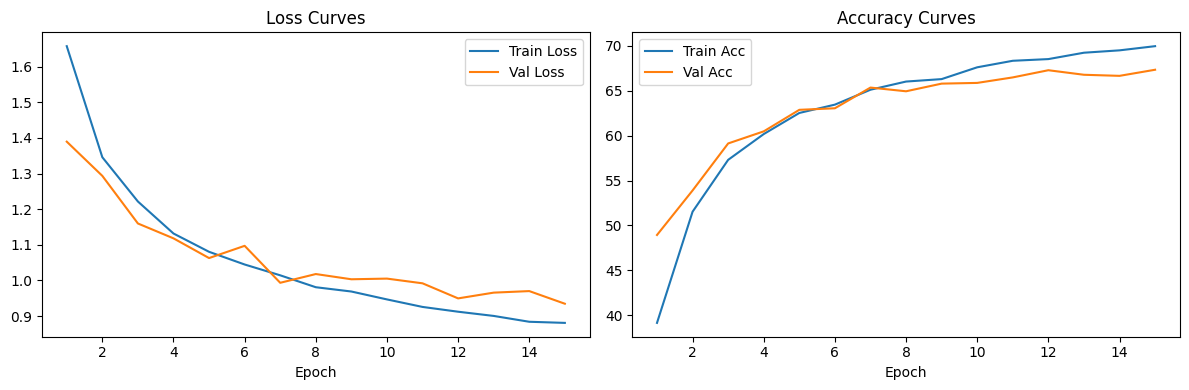

In [22]:
#hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "no_pooling_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "NoPoolingCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_no_pooling = NoPoolingCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_no_pooling.parameters(), lr=learning_rate, momentum=0.9)

train_losses_no_pooling, val_losses_no_pooling = [], []
train_accs_no_pooling, val_accs_no_pooling = [], []

print(">>> Training on CIFAR-10 train/val with NoPoolingCNN starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_no_pooling, ta_no_pooling = train_one_epoch(model_no_pooling, train_loader, criterion, optimizer, ep)

    # validation
    vl_no_pooling, va_no_pooling = eval_one_epoch(
        model_no_pooling,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_no_pooling.append(tl_no_pooling)
    train_accs_no_pooling.append(ta_no_pooling)
    val_losses_no_pooling.append(vl_no_pooling)
    val_accs_no_pooling.append(va_no_pooling)
    
    print(f"Epoche {ep:02d}: Train L={tl_no_pooling:.4f}, A={ta_no_pooling:.1f}%;  Val L={vl_no_pooling:.4f}, A={va_no_pooling:.1f}%")
    
plot_learning_curves(train_losses_no_pooling, val_losses_no_pooling, train_accs_no_pooling, val_accs_no_pooling)

In [23]:
precision_no_pooling, recall_no_pooling, f1_no_pooling = compute_metrics(model_no_pooling, test_loader)
_, test_acc_no_pooling = eval_one_epoch(model_no_pooling, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_no_pooling:.1f}%")
print(f"Precision: {precision_no_pooling:.3f}, Recall: {recall_no_pooling:.3f}, F1: {f1_no_pooling:.3f}")
wandb.log({
    "test_accuracy": test_acc_no_pooling,
    "test_precision": precision_no_pooling,
    "test_recall": recall_no_pooling,
    "test_f1_score": f1_no_pooling
})

Test Accuracy: 71.5%
Precision: 0.720, Recall: 0.715, F1: 0.716


---

In [24]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.drop1 = nn.Dropout(p=0.5)           # neues Dropout
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = x.view(x.size(0), -1)                  # [B, 64*8*8]
        x = torch.relu(self.fc1(x))                # [B, 128]
        x = self.drop1(x)                          # Dropout-Schicht
        return self.fc2(x)                         # [B, num_classes]

In [25]:
print("Params DropoutCNN:", count_parameters(DropoutCNN(num_classes)))

Params DropoutCNN: 545098


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇█████
val_loss,█▇▄▄▃▄▂▂▂▂▂▁▁▂▁
epoch,15
test_accuracy,71.51


>>> Training on CIFAR-10 train/val with DropoutCNN starts ...
Epoche 01: Train L=1.7564, A=34.6%;  Val L=1.4727, A=45.9%
Epoche 02: Train L=1.4961, A=45.3%;  Val L=1.3185, A=52.5%
Epoche 03: Train L=1.3787, A=50.6%;  Val L=1.2471, A=54.7%
Epoche 04: Train L=1.3151, A=53.5%;  Val L=1.1500, A=58.7%
Epoche 05: Train L=1.2783, A=55.1%;  Val L=1.1421, A=59.0%
Epoche 06: Train L=1.2488, A=56.1%;  Val L=1.1247, A=60.8%
Epoche 07: Train L=1.2385, A=56.7%;  Val L=1.1065, A=60.9%
Epoche 08: Train L=1.2178, A=57.3%;  Val L=1.1487, A=59.5%
Epoche 09: Train L=1.2040, A=58.0%;  Val L=1.0492, A=63.3%
Epoche 10: Train L=1.1827, A=58.8%;  Val L=1.0252, A=63.9%
Epoche 11: Train L=1.1896, A=58.6%;  Val L=1.0865, A=62.5%
Epoche 12: Train L=1.1787, A=59.1%;  Val L=1.0602, A=63.4%
Epoche 13: Train L=1.1761, A=59.2%;  Val L=1.0834, A=62.6%
Epoche 14: Train L=1.1697, A=59.8%;  Val L=1.0345, A=63.8%
Epoche 15: Train L=1.1613, A=60.0%;  Val L=1.0996, A=62.8%


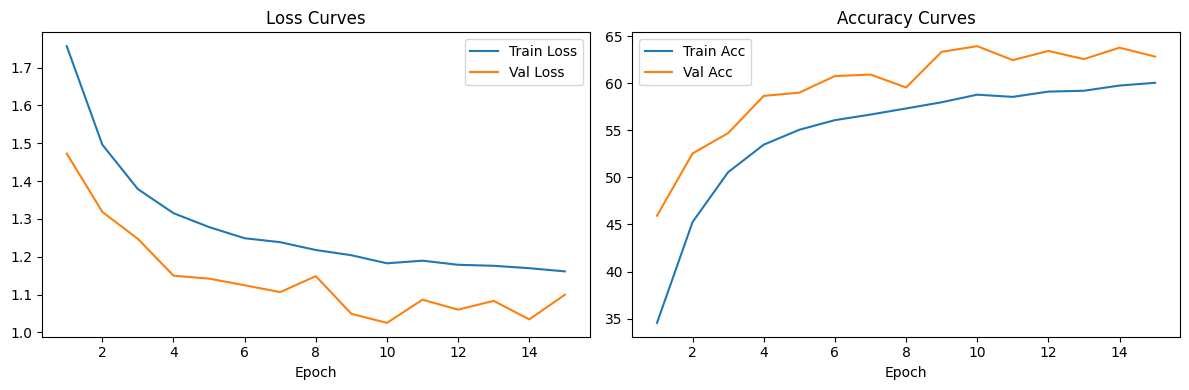

In [26]:
#hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "dropout_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "DropoutCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_dropout = DropoutCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)

train_losses_dropout, val_losses_dropout = [], []
train_accs_dropout, val_accs_dropout = [], []

print(">>> Training on CIFAR-10 train/val with DropoutCNN starts ...")
for ep in range(1, epochs + 1):
    # training
    tl_dropout, ta_dropout = train_one_epoch(model_dropout, train_loader, criterion, optimizer, ep)

    # validation
    vl_dropout, va_dropout = eval_one_epoch(
        model_dropout,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_dropout.append(tl_dropout)
    train_accs_dropout.append(ta_dropout)
    val_losses_dropout.append(vl_dropout)
    val_accs_dropout.append(va_dropout)
    
    print(f"Epoche {ep:02d}: Train L={tl_dropout:.4f}, A={ta_dropout:.1f}%;  Val L={vl_dropout:.4f}, A={va_dropout:.1f}%")
    
plot_learning_curves(train_losses_dropout, val_losses_dropout, train_accs_dropout, val_accs_dropout)

In [27]:
precision_dropout, recall_dropout, f1_dropout = compute_metrics(model_dropout, test_loader)
_, test_acc_dropout = eval_one_epoch(model_dropout, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, split_name="test")

print(f"Test Accuracy: {test_acc_dropout:.1f}%")
print(f"Precision: {precision_dropout:.3f}, Recall: {recall_dropout:.3f}, F1: {f1_dropout:.3f}")

wandb.log({
    "test_accuracy": test_acc_dropout,
    "test_precision": precision_dropout,
    "test_recall": recall_dropout,
    "test_f1_score": f1_dropout
})

Test Accuracy: 65.8%
Precision: 0.672, Recall: 0.658, F1: 0.653


---

In [39]:
def train_one_epoch(model, loader, criterion, optimizer, epoch=None, log_to_wandb=True, prefix=""):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds      = outputs.max(1)
        correct      += (preds == labels).sum().item()
        total        += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and (epoch is not None):
        wandb.log({
            f"{prefix}train_loss": epoch_loss,
            f"{prefix}train_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, epoch=None, log_to_wandb=True, prefix=""):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds      = outputs.max(1)
            correct      += (preds == labels).sum().item()
            total        += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = 100 * correct / total

    if log_to_wandb and (epoch is not None):
        wandb.log({
            f"{prefix}val_loss": epoch_loss,
            f"{prefix}val_accuracy": epoch_acc,
            "epoch": epoch
        })
    return epoch_loss, epoch_acc

In [ ]:
class RandomCutout(object):
    def __init__(self, size, p=0.5):
        self.size = size  # Seitenlänge des Quadrats
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        top = random.randint(0, h - self.size)
        left = random.randint(0, w - self.size)
        mask = Image.new('RGB', (w, h), (0, 0, 0))
        img.paste(mask.crop((left, top, left + self.size, top + self.size)), (left, top))
        return img
    
class RandomCutout(object):
    def __init__(self, size, p=0.5):
        self.size = size  # Seitenlänge des Quadrats
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        top = random.randint(0, h - self.size)
        left = random.randint(0, w - self.size)
        mask = Image.new('RGB', (w, h), (0, 0, 0))
        img.paste(mask.crop((left, top, left + self.size, top + self.size)), (left, top))
        return img

In [31]:
# Fixiere den Zufallsseed für Reproduzierbarkeit
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Hyperparameter (konstant für beide Läufe Q und R)
epochs     = 20
batch_size = 16
lr         = 1e-3
momentum   = 0.9

# W&B Initialisierung
wandb.init(
    project="image-classification",
    name="DataAugmentation_Run",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "momentum": momentum
    }
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▆▇▇▇▇▇██████
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▆▆▇▇▆██▇█▇██
val_loss,█▆▄▃▃▃▂▃▁▁▂▂▂▁▂
epoch,15
test_accuracy,65.77


In [35]:
class RandomCutout(object):
    def __init__(self, size, p=0.5):
        self.size = size  # Seitenlänge des Quadrats
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        top = random.randint(0, h - self.size)
        left = random.randint(0, w - self.size)
        mask = Image.new('RGB', (w, h), (0, 0, 0))
        img.paste(mask.crop((left, top, left + self.size, top + self.size)), (left, top))
        return img

In [43]:
# (a) Transform für Test/Daten ohne Augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# (b) Baseline-Transform (RandomCrop + RandomHorizontalFlip)
transform_baseline = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# (c) Erweiterte Augmentation: Crop + Flip + Rotation + Cutout
transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),                # ±15° Rotation
    RandomCutout(size=8, p=0.5),                  # Cutout-Patch 8×8 Px, p=0.5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# (d) Lade CIFAR-10 mit Baseline-Transform (für Run Q)
cifar10_full_baseline = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_baseline
)

# (e) Lade CIFAR-10 mit Erweiterter Augmentation (für Run R)
cifar10_full_augmented = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=False, transform=transform_augmented
)

# (f) Lade das offizielle Testset (keine Augmentation, nur Normalisierung)
cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=False, transform=transform_test
)

# -------------------------------
# 6) Splits: Train/Val/Test
#    (85% Train, 15% Val)
# -------------------------------
# Anzahl gesamt Train-Bilder
N_total = len(cifar10_full_baseline)  # 50.000

# 85/15-Split
train_len = int(0.85 * N_total)  # 42.500
val_len   = N_total - train_len  # 7.500

# (a) Split für Run Q (Baseline-Augmentation)
train_ds_Q, val_ds_Q = random_split(
    cifar10_full_baseline,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(seed)
)

# (b) Split für Run R (Erweiterte Augmentation)
train_ds_R, val_ds_R = random_split(
    cifar10_full_augmented,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(seed)
)

# (c) Dataloader erstellen
train_loader_Q = DataLoader(train_ds_Q, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_Q   = DataLoader(val_ds_Q,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

train_loader_R = DataLoader(train_ds_R, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader_R   = DataLoader(val_ds_R,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

test_loader    = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Run Q (Baseline-Aug)  → Train/Val Sizes: {len(train_ds_Q)}/{len(val_ds_Q)}")
print(f"Run R (Erweiterte Aug)→ Train/Val Sizes: {len(train_ds_R)}/{len(val_ds_R)}")
print(f"Test-Set Size: {len(cifar10_test)}")

Run Q (Baseline-Aug)  → Train/Val Sizes: 42500/7500
Run R (Erweiterte Aug)→ Train/Val Sizes: 42500/7500
Test-Set Size: 10000


In [40]:
print("\n>>>> RUN Q: Baseline-Augmentation (RandomCrop + RandomHorizontalFlip)")

# Model, criterion, optimizer
model_Q = BaselineCNN(num_classes=10).to(device)
optimizer_Q = optim.SGD(model_Q.parameters(), lr=lr, momentum=momentum)
criterion_Q = nn.CrossEntropyLoss()

train_losses_Q, val_losses_Q = [], []
train_accs_Q,   val_accs_Q   = [], []

start_time_Q = time.time()
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(
        model_Q, train_loader_Q, criterion_Q, optimizer_Q, epoch=ep, log_to_wandb=True, prefix="Q_"
    )
    vl, va = eval_one_epoch(
        model_Q, val_loader_Q, criterion_Q, epoch=ep, log_to_wandb=True, prefix="Q_"
    )
    train_losses_Q.append(tl)
    train_accs_Q.append(ta)
    val_losses_Q.append(vl)
    val_accs_Q.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.2f}%  |  Val L={vl:.4f}, A={va:.2f}%")

total_time_Q = time.time() - start_time_Q
print(f"Run Q fertig in {total_time_Q:.1f} Sekunden.")

# Nach Training: finale Test-Metriken (Q)
precision_Q, recall_Q, f1_Q = compute_metrics(model_Q, test_loader)
_, test_acc_Q = eval_one_epoch(model_Q, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, prefix="Q_")
print(f"Run Q → Test-Accuracy: {test_acc_Q:.2f}%, Precision: {precision_Q:.3f}, Recall: {recall_Q:.3f}, F1: {f1_Q:.3f}")



>>>> RUN Q: Baseline-Augmentation (RandomCrop + RandomHorizontalFlip)
Epoche 01: Train L=1.8828, A=31.47%  |  Val L=1.6351, A=40.92%
Epoche 02: Train L=1.5291, A=44.16%  |  Val L=1.4426, A=47.00%
Epoche 03: Train L=1.4017, A=48.96%  |  Val L=1.3607, A=50.55%
Epoche 04: Train L=1.2962, A=53.20%  |  Val L=1.2814, A=53.61%
Epoche 05: Train L=1.2009, A=57.07%  |  Val L=1.1468, A=59.00%
Epoche 06: Train L=1.1297, A=59.67%  |  Val L=1.0963, A=61.03%
Epoche 07: Train L=1.0609, A=62.28%  |  Val L=1.0922, A=61.01%
Epoche 08: Train L=1.0169, A=64.10%  |  Val L=0.9999, A=64.64%
Epoche 09: Train L=0.9720, A=65.67%  |  Val L=1.0293, A=63.57%
Epoche 10: Train L=0.9427, A=66.60%  |  Val L=0.9507, A=66.63%
Epoche 11: Train L=0.9036, A=68.00%  |  Val L=0.9132, A=67.79%
Epoche 12: Train L=0.8775, A=69.03%  |  Val L=0.8826, A=68.40%
Epoche 13: Train L=0.8484, A=70.02%  |  Val L=0.9158, A=68.17%
Epoche 14: Train L=0.8293, A=71.23%  |  Val L=0.8991, A=68.35%
Epoche 15: Train L=0.8051, A=71.72%  |  Val L=0

In [44]:
print("\n>>>> RUN R: Erweiterte Augmentation (RandomCrop + Flip + Rotation + Cutout)")

model_R     = BaselineCNN(num_classes=10).to(device)
optimizer_R = optim.SGD(model_R.parameters(), lr=lr, momentum=momentum)
criterion_R = nn.CrossEntropyLoss()

train_losses_R, val_losses_R = [], []
train_accs_R,   val_accs_R   = [], []

start_time_R = time.time()
for ep in range(1, epochs+1):
    tl, ta = train_one_epoch(
        model_R, train_loader_R, criterion_R, optimizer_R, epoch=ep, log_to_wandb=True, prefix="R_"
    )
    vl, va = eval_one_epoch(
        model_R, val_loader_R, criterion_R, epoch=ep, log_to_wandb=True, prefix="R_"
    )
    train_losses_R.append(tl)
    train_accs_R.append(ta)
    val_losses_R.append(vl)
    val_accs_R.append(va)
    print(f"Epoche {ep:02d}: Train L={tl:.4f}, A={ta:.2f}%  |  Val L={vl:.4f}, A={va:.2f}%")

total_time_R = time.time() - start_time_R
print(f"Run R fertig in {total_time_R:.1f} Sekunden.")

# Nach Training: finale Test-Metriken (R)
precision_R, recall_R, f1_R = compute_metrics(model_R, test_loader)
_, test_acc_R = eval_one_epoch(model_R, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False, prefix="R_")
print(f"Run R → Test-Accuracy: {test_acc_R:.2f}%, Precision: {precision_R:.3f}, Recall: {recall_R:.3f}, F1: {f1_R:.3f}")



>>>> RUN R: Erweiterte Augmentation (RandomCrop + Flip + Rotation + Cutout)
Epoche 01: Train L=1.9368, A=29.30%  |  Val L=1.7261, A=37.41%
Epoche 02: Train L=1.6386, A=40.05%  |  Val L=1.5945, A=41.16%
Epoche 03: Train L=1.5268, A=44.64%  |  Val L=1.5632, A=43.59%
Epoche 04: Train L=1.4447, A=47.43%  |  Val L=1.3874, A=49.16%
Epoche 05: Train L=1.3705, A=50.20%  |  Val L=1.3570, A=50.55%
Epoche 06: Train L=1.3126, A=52.46%  |  Val L=1.3760, A=49.53%
Epoche 07: Train L=1.2492, A=55.13%  |  Val L=1.2361, A=55.81%
Epoche 08: Train L=1.2050, A=56.81%  |  Val L=1.1999, A=57.24%
Epoche 09: Train L=1.1585, A=58.61%  |  Val L=1.1448, A=59.21%
Epoche 10: Train L=1.1207, A=59.94%  |  Val L=1.1224, A=59.65%
Epoche 11: Train L=1.0924, A=61.11%  |  Val L=1.1083, A=60.67%
Epoche 12: Train L=1.0628, A=62.08%  |  Val L=1.0583, A=62.71%
Epoche 13: Train L=1.0306, A=63.10%  |  Val L=1.0403, A=63.01%
Epoche 14: Train L=1.0101, A=63.95%  |  Val L=1.0193, A=63.71%
Epoche 15: Train L=0.9898, A=64.92%  |  V

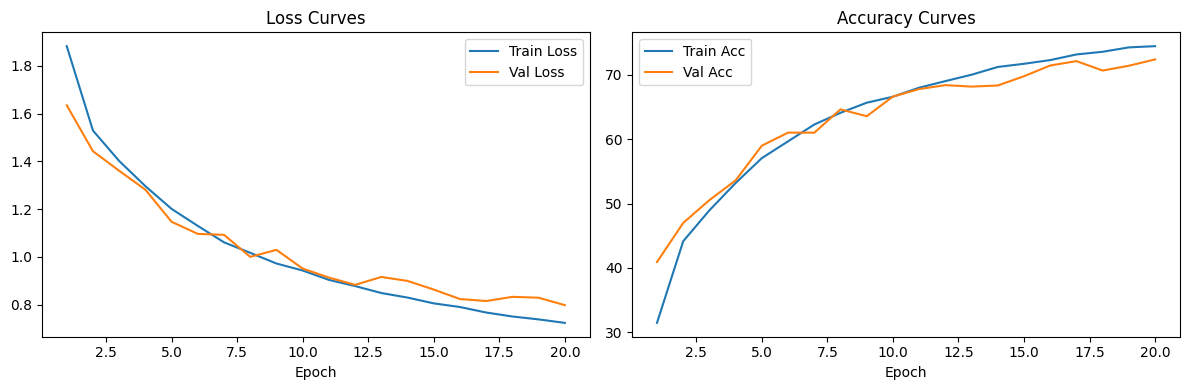

In [48]:
plot_learning_curves(
    train_losses_Q, val_losses_Q, train_accs_Q, val_accs_Q
)

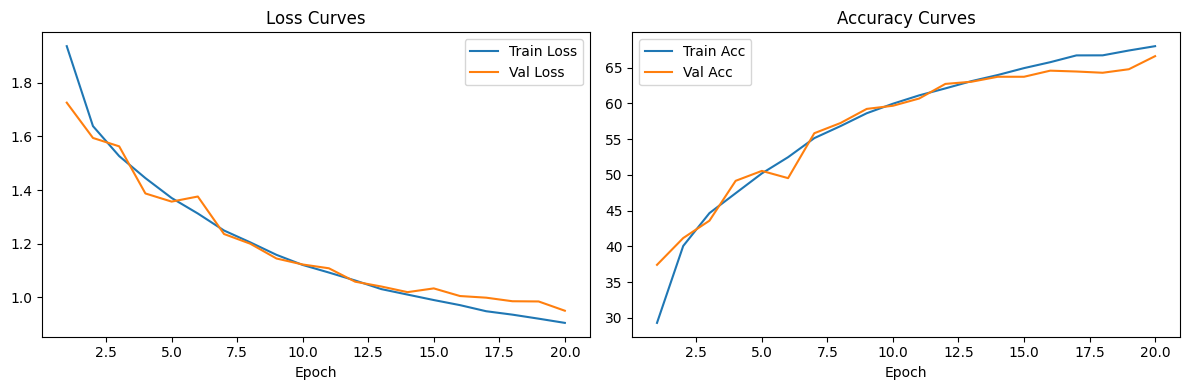

In [49]:
plot_learning_curves(
    train_losses_R, val_losses_R, train_accs_R, val_accs_R
)

In [50]:
print("\n===== Zusammenfassung =====")
print(f"Run Q (Baseline-Aug): Val L (letzte Epoche) = {val_losses_Q[-1]:.4f}, Val A = {val_accs_Q[-1]:.2f}%")
print(f"Run R (Augmented):    Val L (letzte Epoche) = {val_losses_R[-1]:.4f}, Val A = {val_accs_R[-1]:.2f}%\n")

print(f"Run Q → Test-Accuracy: {test_acc_Q:.2f}%, Precision: {precision_Q:.3f}, Recall: {recall_Q:.3f}, F1: {f1_Q:.3f}")
print(f"Run R → Test-Accuracy: {test_acc_R:.2f}%, Precision: {precision_R:.3f}, Recall: {recall_R:.3f}, F1: {f1_R:.3f}")


===== Zusammenfassung =====
Run Q (Baseline-Aug): Val L (letzte Epoche) = 0.7975, Val A = 72.40%
Run R (Augmented):    Val L (letzte Epoche) = 0.9500, Val A = 66.59%

Run Q → Test-Accuracy: 74.64%, Precision: 0.752, Recall: 0.746, F1: 0.742
Run R → Test-Accuracy: 72.77%, Precision: 0.728, Recall: 0.728, F1: 0.726


In [ ]:
class BatchNormCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # Conv → BN → ReLU
        x = self.pool(x)                          # [B, 32, 16, 16]
        x = torch.relu(self.bn2(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(x)
        x = x.view(x.size(0), -1)                 # [B, 64*8*8]
        x = torch.relu(self.fc1(x))               # [B, 128]
        return self.fc2(x)   

In [ ]:
print("Params BatchNormCNN:", count_parameters(BatchNormCNN(num_classes)))

In [ ]:
# Hyperparameter
epochs = 15
batch_size = 16
learning_rate = 0.01
project_name = "image-classification"
run_name = "batchnorm_cnn"

# W&B Init
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "architecture": "BatchNormCNN",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

# Model, criterion, optimizer
model_batchnorm = BatchNormCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_batchnorm.parameters(), lr=learning_rate, momentum=0.9)

train_losses_batchnorm, val_losses_batchnorm = [], []
train_accs_batchnorm,   val_accs_batchnorm   = [], []

print(">>> Training on CIFAR-10 train/val with BatchNormCNN starts ...")
start_time = time.time()
for ep in range(1, epochs+1):
    # training
    tl_batchnorm, ta_batchnorm = train_one_epoch(model_batchnorm, train_loader, criterion, optimizer, ep)

    # validation
    vl_batchnorm, va_batchnorm = eval_one_epoch(
        model_batchnorm,
        val_loader,
        criterion,
        epoch=ep,            
        split_name="val"     
    )

    train_losses_batchnorm.append(tl_batchnorm)
    train_accs_batchnorm.append(ta_batchnorm)
    val_losses_batchnorm.append(vl_batchnorm)
    val_accs_batchnorm.append(va_batchnorm)
    print(f"Epoche {ep:02d}: Train L={tl_batchnorm:.4f}, A={ta_batchnorm:.2f}%  |  Val L={vl_batchnorm:.4f}, A={va_batchnorm:.2f}%")

total_time = time.time() - start_time
print(f"Run fertig in {total_time:.1f} Sekunden.")

# Plot learning curves
plot_learning_curves(train_losses_batchnorm, val_losses_batchnorm, train_accs_batchnorm, val_accs_batchnorm)

In [ ]:
precision_batchnorm, recall_batchnorm, f1_batchnorm = compute_metrics(model_batchnorm, test_loader)
_, test_acc_batchnorm = eval_one_epoch(model_batchnorm, test_loader, nn.CrossEntropyLoss(), epoch=None, log_to_wandb=False)

print(f"Test Accuracy: {test_acc_batchnorm:.2f}%")
print(f"Precision: {precision_batchnorm:.3f}, Recall: {recall_batchnorm:.3f}, F1: {f1_batchnorm:.3f}")

wandb.log({
    "test_accuracy": test_acc_batchnorm,
    "test_precision": precision_batchnorm,
    "test_recall": recall_batchnorm,
    "test_f1_score": f1_batchnorm
})

---

# Schritt 4: Hyperparameter Tuning

In diesem Schritt formulieren wir 10 Hypothesen aus den vorgegebenen Gruppen, führen Experimente durch und reflektieren die Ergebnisse.

## 4.1 Hypothese 1: Kleinere Lernrate (SGD)

Erwartung: Reduzierte Lernrate (0.001 vs. 0.0001) führt zu langsamerem, aber stabilerem Abfall des Trainingsverlusts und ggf. besserer Validierungsaccuracy.

In [1]:
lr_small = 0.0001

# W&B Init für Hypothese 1
wandb.init(
    project=project_name,
    name="hypothesis1_lower_lr",
    config={"hypothesis": "lower_lr",
            "learning_rate": lr_small,
            "epochs": epochs,
            "batch_size": batch_size}
)

NameError: name 'wandb' is not defined